## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../data/data.txt'
# if not os.path.exists(path_do_data):
#     print("Dataset not found locally. Downloading from github. Loading special files as well")
#     !wget https://yadi.sk/d/LWdzzg7vIUdqhw -nc
#     path_do_data = './data.txt'

In [4]:
# if not os.path.exists('./utils.py'):
#     print("utils file not found locally. Downloading from github.")
#     !wget https://disk.yandex.ru/d/dTy422j3K07LyQ -nc

# if not os.path.exists('./my_network.py'):
#     print("network file not found locally. Downloading from github.")
#     !wget https://disk.yandex.ru/d/pkkNUfn4Af_n3w -nc

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.experimental.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [11]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

**<font color=blue>Observations:</font>**

Tokenization of russian words is not that simple compared to english words, mainly because of the presence of compound words or word connected by hyphens. In that case word like `какой-то` will give multiple tokens, which separately convey the meaning of neither the original russian nor the target english word.

In [12]:
text = "Не ветер, а какой-то ураган!"

In [13]:
tokenize(text)

['не', 'ветер', ',', 'а', 'какой', '-', 'то', 'ураган', '!']

To deal with this we'll use spacy's out-of-the-box tokenization and text segmentation API that can handle more accurate rules for the russian language.

The vocabulary of patterns is obtained from National Russian Language Corpus (НКРЯ). For more details on the API see [here](https://github.com/aatimofeev/spacy_russian_tokenizer).

In [14]:
!pip install pymorphy2==0.8


     |███████                         | 10kB 19.1MB/s eta 0:00:01
     |██████████████▏                 | 20kB 11.7MB/s eta 0:00:01
     |█████████████████████▎          | 30kB 9.2MB/s eta 0:00:01
     |████████████████████████████▍   | 40kB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 7.1MB 8.1MB/s 


In [15]:
from spacy.lang.ru import Russian

In [16]:
!pip install git+https://github.com/aatimofeev/spacy_russian_tokenizer.git

  Cloning https://github.com/aatimofeev/spacy_russian_tokenizer.git to /tmp/pip-req-build-l2jgg8ud
  Running command git clone -q https://github.com/aatimofeev/spacy_russian_tokenizer.git /tmp/pip-req-build-l2jgg8ud
  Created wheel for spacy-russian-tokenizer: filename=spacy_russian_tokenizer-0.1.1-cp37-none-any.whl size=12675 sha256=c07812e02509c4c76e7a78452115bf5f1b0eb62c1097c664d3ba6524fb8a0801
  Stored in directory: /tmp/pip-ephem-wheel-cache-6dsvzmf4/wheels/37/3b/bb/cfe712f7c0b78cd08f4a2ef122d17748baf9d4bebecf2e5a54
Successfully built spacy-russian-tokenizer


In [17]:
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS

In [18]:
nlp = Russian()
russian_tokenizer = RussianTokenizer(nlp, MERGE_PATTERNS)
nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')
def rus_tokenize(x, tokenizer=nlp):
  tokens = nlp(x.lower())
  return [token.text for token in tokens]

In [19]:
tokenize(text)

['не', 'ветер', ',', 'а', 'какой', '-', 'то', 'ураган', '!']

In [20]:
rus_tokenize(text)

['не', 'ветер', ',', 'а', 'какой-то', 'ураган', '!']

For english language WordPunctTokenizer should be enough.

In [21]:
tokenizer_W = WordPunctTokenizer()
def en_tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [22]:
SRC = Field(tokenize=rus_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=en_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [23]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [24]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [25]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [26]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9282
Unique tokens in target (en) vocabulary: 6724


Here are tokens from original (RU) corpus:

In [27]:
SRC.vocab.itos[::1000]

['<unk>',
 'отдыхать',
 '650',
 'леха',
 'baymont',
 'шанхайского',
 'marbella',
 'уединенной',
 'детали',
 'суеты']

And from target (EN) corpus:

In [28]:
TRG.vocab.itos[::1000]

['<unk>', 'packed', 'groves', 'carlos', 'menaggio', 'sonne', 'mantar']

And here is example from train dataset:

In [29]:
vars(train_data.examples[5])['src']

['отель',
 'grand',
 'holiday',
 '2',
 'расположен',
 'в',
 'центре',
 'ханоя',
 ',',
 'всего',
 'в',
 '500',
 'метрах',
 'от',
 'храма',
 'нгок',
 'сон',
 '.']

In [30]:
vars(train_data.examples[5])['trg']

['grand',
 'holiday',
 'hotel',
 '2',
 'is',
 'situated',
 'in',
 'the',
 'heart',
 'of',
 'hanoi',
 ',',
 'just',
 '500',
 'metres',
 'from',
 'ngoc',
 'son',
 'temple',
 '.',
 'st',
 '.']

In [31]:
print(vars(train_data.examples[9]))

{'trg': ['set', '3', '.', '5', 'km', 'from', 'the', 'historical', 'centre', 'of', 'lecce', ',', 'b', '&', 'b', 'beev', 'offers', 'free', 'private', 'parking', 'on', 'site', 'and', 'free', 'wi', '-', 'fi', 'throughout', '.', 'rooms', 'here', 'are', 'classically', 'furnished', '.'], 'src': ['отель', 'типа', '«', 'постель', 'и', 'завтрак', '»', 'beev', 'находится', 'в', '3,5', 'км', 'от', 'исторического', 'центра', 'города', 'лечче', '.', 'к', 'услугам', 'гостей', 'бесплатная', 'частная', 'парковка', ',', 'бесплатный', 'wifi', 'на', 'всей', 'территории', 'и', 'оформленные', 'в', 'классическом', 'стиле', 'номера', '.']}


Let's check the length distributions:

Length distribution in Train data


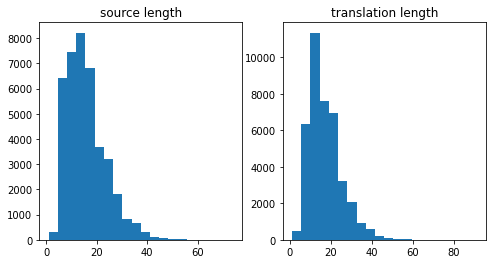

In [32]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


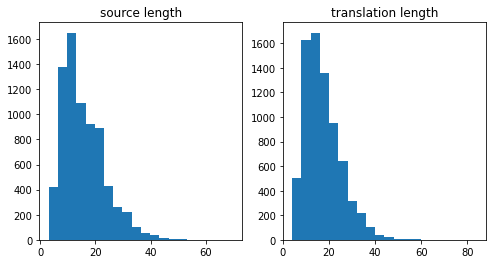

In [33]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
device

device(type='cuda')

In [36]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [37]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 50x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 53x128 (GPU 0)]
torch.Size([53, 128]) torch.Size([50, 128])


In [38]:
from models import network
Encoder = network.Encoder
Decoder = network.Decoder
Seq2Seq = network.Seq2Seq

In [39]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [40]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9282, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6724, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6724, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,903,364 trainable parameters


In [42]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [43]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # src = [src sent len, batch size]
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [44]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

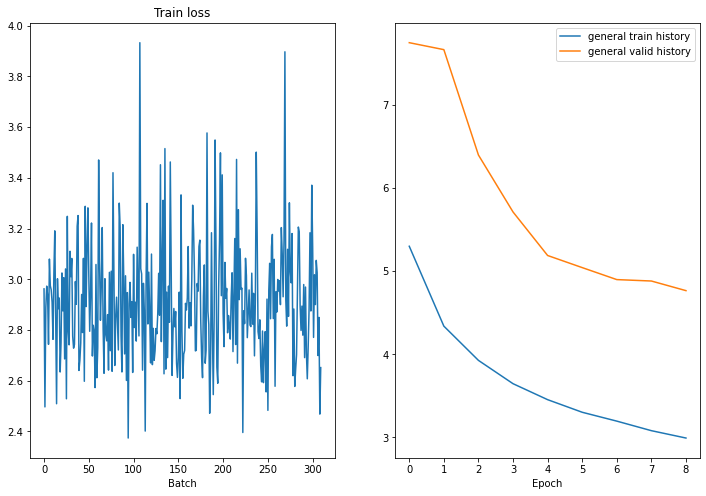

Epoch: 10 | Time: 2m 28s
	Train Loss: 2.908 | Train PPL:  18.318
	 Val. Loss: 4.845 |  Val. PPL: 127.127


In [47]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [48]:
# del utils

In [49]:
from models import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [50]:
batch = next(iter(test_iterator))

In [51]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: parking is free .
Generated: free private parking is available .

Original: a tv is available .
Generated: there is a private bathroom .



In [52]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [53]:
import tqdm

In [54]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05, 11.13it/s]


In [55]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.94341105622846

**<font color=blue>Conclusions:</font>**

- This model does slightly better than the baseline, which implies that a more correct tokenization of russian words may have helped to put a better correspondence between source and target words.
- Repeated experiments may help to elucidate whether this improvements are always expected or not (I mean, the BLUE score here and in the baseline are quite tight).
- One reason why we didn't get the expected improvements may be related to the nature of the text we trained on. The texts dealt with are hotel descriptions, which means that the language used is more formal and words such as `какой-то`, `кто-нибудь` are not met that often (are words that transmit some sense of uncertainty; something we wouldn't expect from a hotel description found in booking.com or somewhere else).

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points